In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import time


## Get image counts

In [2]:
import os

path = "data/train"
dirs = os.listdir(path)

for folder in dirs:
    folder_path = os.path.join(path, folder)
    if os.path.isdir(folder_path):
        num_files = len(os.listdir(folder_path))
        print(f"Number of images in {folder}: {num_files}")


Number of images in Closed: 726
Number of images in no_yawn: 725
Number of images in Open: 726
Number of images in yawn: 723


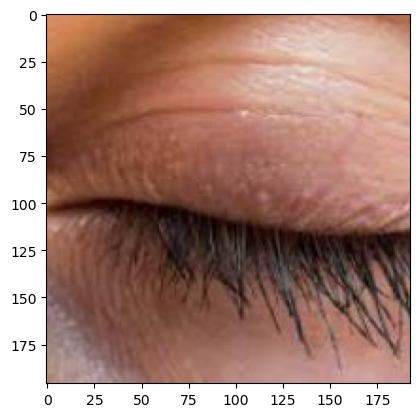

In [3]:
random_img = "data/train/Closed/"+ str(np.random.randint(0,700)) +".jpg"
plt.imshow(plt.imread(random_img))
plt.show()

In [4]:
subdir_path = 'data/train/Closed/'

files = os.listdir(subdir_path)
for file in files:
    if file.startswith('_'):
        old_path = os.path.join(subdir_path, file)
        new_path = os.path.join(subdir_path, file[1:])
        os.rename(old_path, new_path)

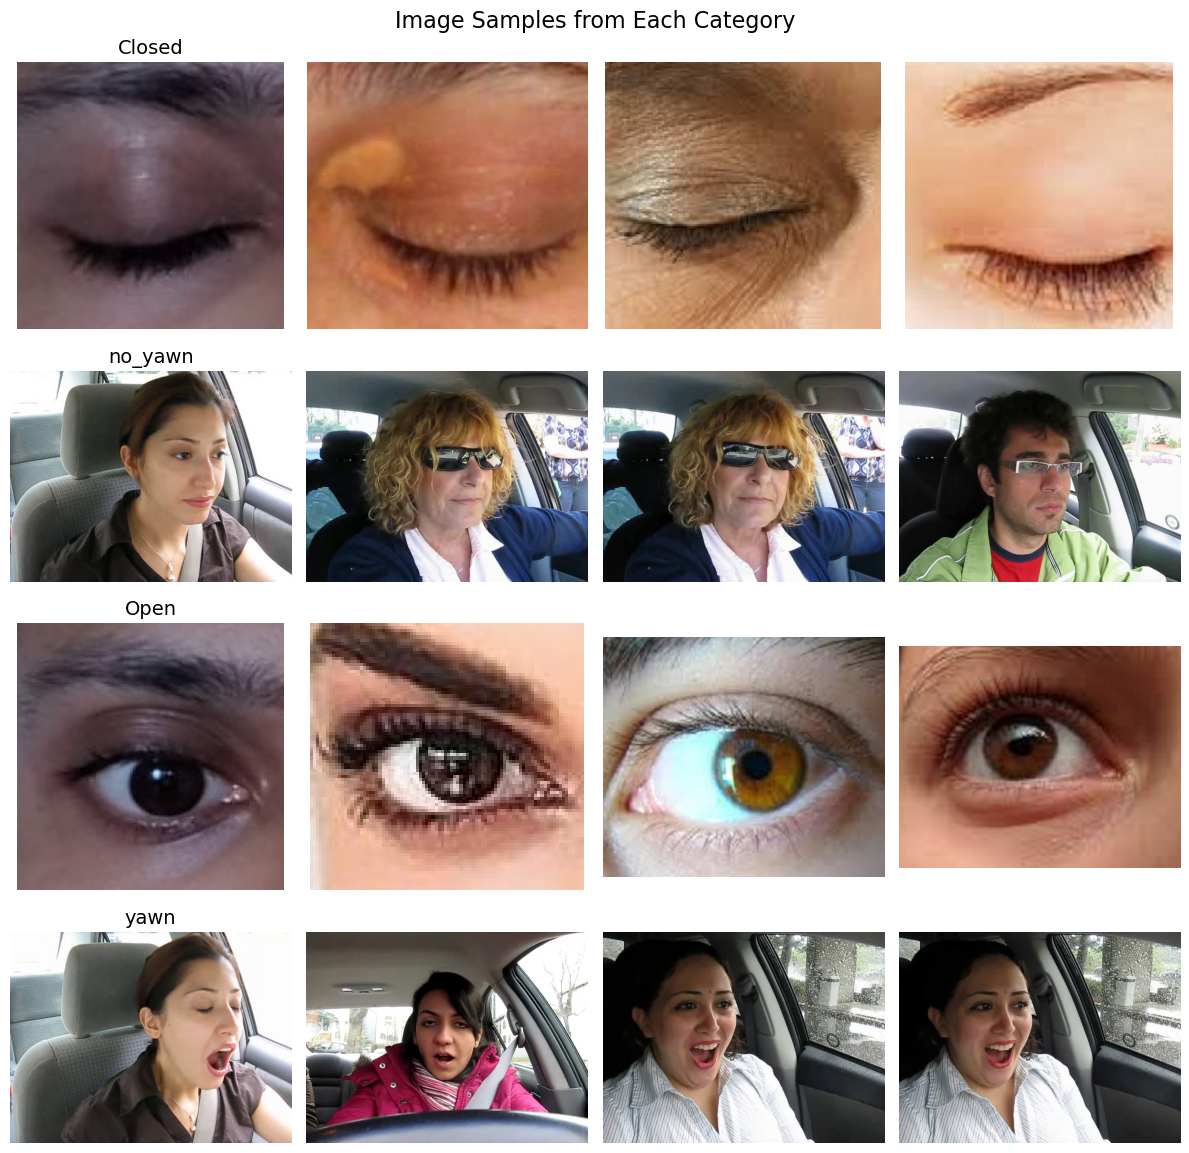

In [5]:
path = "data/train"
dirs = os.listdir(path)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
fig.suptitle('Image Samples from Each Category', fontsize=16)

for i, folder in enumerate(dirs):
    folder_path = os.path.join(path, folder)
    if os.path.isdir(folder_path):
        axs[i, 0].set_title(folder, fontsize=14)
        for j, file in enumerate(os.listdir(folder_path)[:4]):
            file_path = os.path.join(folder_path, file)
            img = Image.open(file_path)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            
plt.tight_layout()
plt.show()

Random Files shape

In [6]:


path = "data/train"
dirs = ["Closed", "no_yawn", "Open", "yawn"]

for folder in dirs:
    folder_path = os.path.join(path, folder)
    if os.path.isdir(folder_path):
        files = os.listdir(folder_path)
        if len(files) > 0:
            file_name = np.random.choice(files)
            file_path = os.path.join(folder_path, file_name)
            img = Image.open(file_path)
            print(f"{folder} file shape: {img.size}")

Closed file shape: (766, 766)
no_yawn file shape: (640, 480)
Open file shape: (450, 300)
yawn file shape: (640, 480)


The files in each directory are of different shapes

## Backgound removal

The yawn and no-yawn images have backgound. so remove the backgorund

In [7]:
class DrowsyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)

    def __len__(self):
        length = 0
        for c in self.classes:
            class_dir = os.path.join(self.root_dir, c)
            length += len(os.listdir(class_dir))
        return length

    def __getitem__(self, idx):
        """
        gets an image and its corresponding label at a given index. 
        It first determines the class of the image by iterating over the subdirectories until it finds the correct index. 
        It then loads the image using OpenCV, converts it to RGB format, 
        and applies the specified transform if one was provided
        
        """

        img_label = None
        class_idx = 0

        for c in self.classes:
            class_dir = os.path.join(self.root_dir, c)
            if idx < len(os.listdir(class_dir)):
                img_name = os.listdir(class_dir)[idx]
                img_path = os.path.join(class_dir, img_name)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_label = c
                break
            else:
                idx -= len(os.listdir(class_dir))
                class_idx += 1

        # Convert image to PIL format
        pil_img = Image.fromarray(img)

        if self.transform:
            pil_img = self.transform(pil_img)

        # Apply background removal for "yawn" and "no_yawn" classes if the image has a face
        if img_label in ["yawn", "no_yawn"]:
            face_cascade = cv2.CascadeClassifier('data/haar/haarcascade_frontalface_default.xml')
            gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.2, minNeighbors=5)
            
            # Check if at least one face is detected
            if len(faces) > 0:
                # Create a mask for each face region
                masks = []
                for (x,y,w,h) in faces:
                    mask = np.zeros_like(img[:,:,0])
                    cv2.rectangle(mask, (x,y), (x+w,y+h), (255, 255, 255), -1)
                    masks.append(mask)
            
                # Combine the masks into a single mask
                mask = np.zeros_like(img[:,:,0])
                for m in masks:
                    mask |= m
                
                # Get the bounding box of the mask
                coords = cv2.findNonZero(mask)
                assert coords is not None, f"No face detected in {img_path}"
                x, y, w, h = cv2.boundingRect(coords)

                # Crop the image based on the bounding box of the mask
                cropped_img = img[y:y+h, x:x+w]

                # Apply the mask to the original image
                masked_img = cv2.bitwise_and(cropped_img, cropped_img, mask=mask)

                # Convert the image to PIL format and apply the transform
                pil_img = transforms.ToPILImage()(masked_img)
                
                if self.transform:
                    pil_img = self.transform(pil_img)
            else:
                # If no face is detected, return None for the image and class_idx
                pil_img = None
                class_idx = None

        return pil_img, class_idx



In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

# Define transforms to be applied on the images
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create instances of the custom dataset class for train, validation and test data
train_data = DrowsyDataset('data/train/', data_transforms)

# Define batch size for DataLoader
batch_size = 32

# Create DataLoader instances for train, validation and test data
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and their corresponding labels
images, labels = next(iter(train_loader))

# Convert images to numpy arrays and unnormalize them
image_array = images.numpy()
image_array = np.transpose(image_array, (0, 2, 3, 1))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_array = std * image_array + mean
image_array = np.clip(image_array, 0, 1)

# Define a list of class names
class_names = train_data.classes

# Plot the images with their corresponding labels
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()
for i in range(8):
    img = image_array[i]
    label = class_names[labels[i]]
    axs[i].imshow(img)
    axs[i].set_title(label)
    axs[i].axis('off')
plt.show()


error: OpenCV(4.6.0) C:\b\abs_74oeeuevib\croots\recipe\opencv-suite_1664548340488\work\modules\core\src\arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'cv::binary_op'


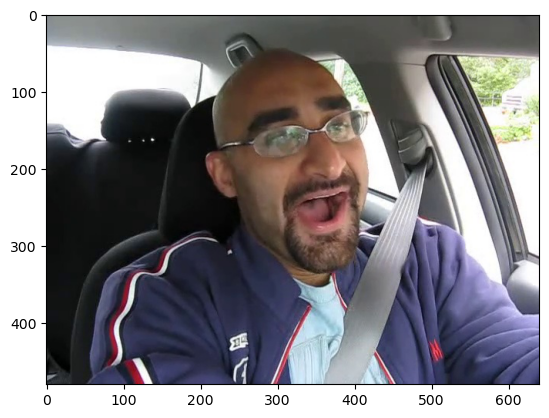

0 0 0 0


TypeError: Image data of dtype object cannot be converted to float

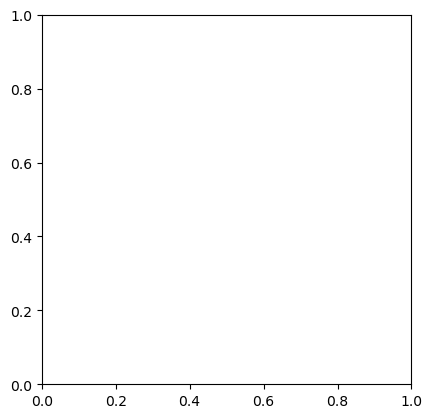

In [ ]:
img_path = "data/train/yawn/"+ str(303) +".jpg"
img = cv2.imread(img_path)
plt.imshow(img[:,:,::-1])
plt.show()

face_cascade = cv2.CascadeClassifier('data/haar/haarcascade_frontalface_default.xml')

faces = face_cascade.detectMultiScale(img, scaleFactor=1.2, minNeighbors=5)

# Create a mask for each face region
masks = []
for (x,y,w,h) in faces:
    mask = np.zeros_like(img[:,:,0])
    cv2.rectangle(mask, (x,y), (x+w,y+h), (255, 255, 255), -1)
    masks.append(mask)

# Combine the masks into a single mask
mask = np.zeros_like(img[:,:,0])
for m in masks:
    mask |= m

# Get the bounding box of the mask
coords = cv2.findNonZero(mask)
x, y, w, h = cv2.boundingRect(coords)
print(x, y, w, h)

# # Crop the image based on the bounding box of the mask
cropped_img = img[y:y+h, x:x+w]

# # Apply the mask to the cropped image
# masked_cropped_img = cv2.bitwise_and(cropped_img, cropped_img, mask=mask[y:y+h, x:x+w])
masked_img = cv2.bitwise_and(cropped_img, cropped_img, mask=mask[y:y+h, x:x+w])


# Display the masked cropped image
plt.imshow(masked_img)
# plt.show()


In [ ]:

# # Load the Mask R-CNN model
# model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
# model.eval()


# image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# tensor = torchvision.transforms.functional.to_tensor(image)

# # Run the model on the image tensor
# with torch.no_grad():
#     outputs = model([tensor])

# # Get the predicted masks and boxes
# masks = outputs[0]["masks"]
# boxes = outputs[0]["boxes"]

# # Apply the masks to the original image
# for i in range(len(masks)):
#     mask = masks[i, 0].numpy()
#     box = boxes[i].numpy().astype(int)
#     x1, y1, x2, y2 = box
#     image[y1:y2, x1:x2][mask > 0.5] = [0, 255, 0]

# # Show the segmented image
# cv2.imshow("Segmented Image", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)


Using cache found in C:\Users\adity/.cache\torch\hub\ultralytics_yolov5_master


requirements: C:\Users\adity\.cache\torch\hub\requirements.txt not found, check failed.


YOLOv5  2023-5-5 Python-3.10.4 torch-1.12.1 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
def detect_faces(image):
    # Convert image to PIL format
    image = Image.fromarray(image)

    # Apply transforms to image
    transform = transforms.Compose([
        transforms.Resize((640, 640)),
        transforms.ToTensor()
    ])
    image = transform(image)

    # Make prediction with YOLOv5 model
    prediction = model(image.unsqueeze(0))

    # Get coordinates of faces
    boxes = prediction[..., :4][0]
    faces = []
    for box in boxes:
        if box[-1] == 0:  # 0 indicates a person
            continue
        elif box[-1] == 1:  # 1 indicates a face
            x1, y1, x2, y2, conf, cls = box.tolist()
            faces.append([int(x1), int(y1), int(x2), int(y2)])
    
    # Remove background for each face
    cropped_faces = []
    for face in faces:
        x1, y1, x2, y2 = face
        roi = image[:, y1:y2, x1:x2]
        mask = model_segmentation(roi.unsqueeze(0)).squeeze(0).sigmoid().cpu().numpy()
        mask = cv2.resize(mask, (x2-x1, y2-y1))
        mask = np.where(mask > 0.5, 1, 0).astype(np.uint8)
        face_masked = cv2.bitwise_and(roi.permute(1, 2, 0).cpu().numpy(), roi.permute(1, 2, 0).cpu().numpy(), mask=mask)
        if np.sum(face_masked) > 0:
            cropped_faces.append(face_masked)
    
    # If no faces detected, return empty list
    if not cropped_faces:
        return []

    # Convert cropped faces to numpy format and display
    output_image = np.hstack(cropped_faces)
    plt.imshow(output_image)
    plt.show()
    
    return cropped_faces





In [ ]:
plt.imshow(y_img)

In [ ]:
# Convert image to PIL format
image = Image.fromarray(y_img)

# Apply transforms to image
transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])
image = transform(image)

# Make prediction with YOLOv5 model
prediction = model(image.unsqueeze(0))

# Get coordinates of faces
boxes = prediction[..., :4][0]
faces = []
for box in boxes:
    if box[-1] == 0:  # 0 indicates a person
        continue
    elif box[-1] == 1:  # 1 indicates a face
        x1, y1, x2, y2, conf, cls = box.tolist()
        faces.append([int(x1), int(y1), int(x2), int(y2)])

for face in faces:
    x1, y1, x2, y2 = face
    roi = image[:, y1:y2, x1:x2]
    mask = model_segmentation(roi.unsqueeze(0)).squeeze(0).sigmoid().cpu().numpy()
    mask = cv2.resize(mask, (x2-x1, y2-y1))
    mask = np.where(mask > 0.5, 1, 0).astype(np.uint8)
    face_masked = cv2.bitwise_and(roi.permute(1, 2, 0).cpu().numpy(), roi.permute(1, 2, 0).cpu().numpy(), mask=mask)
    if np.sum(face_masked) > 0:
        cropped_faces.append(face_masked)

In [ ]:
faces

[]

In [ ]:
plt.imshow(y_img)
plt.show()

In [ ]:
detect_faces(y_img)

[]

In [12]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class YawnDetectionDataset(Dataset):
    def __init__(self, dir_path='data/train/', face_cas='data/haar/haarcascade_frontalface_default.xml', eye_cas='data/haar/haarcascade.xml', img_size=145):
        super(YawnDetectionDataset, self).__init__()
        self.dir_path = dir_path
        self.face_cascade = cv2.CascadeClassifier(face_cas)
        self.eye_cascade = cv2.CascadeClassifier(eye_cas)
        self.img_size = img_size
        self.transform = transforms.Compose([
            transforms.Resize((640, 640)),
            transforms.ToTensor()
        ])
        self.data = []
        self.labels = ['no_yawn', 'yawn']
        self._load_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx][0]
        label = self.data[idx][1]
        img = Image.fromarray(img)
        img = self.transform(img)
        return img, label

    def _load_data(self):
        for label in self.labels:
            path = os.path.join(self.dir_path, label)
            label_idx = self.labels.index(label)
            print(f"Loading data for {label}...")
            for img_name in os.listdir(path):
                img_path = os.path.join(path, img_name)
                img_array = cv2.imread(img_path, cv2.IMREAD_COLOR)
                faces = self.detect_faces(img_array)
                if label == 'no_yawn':
                    if len(faces) > 0:
                        img_array = self.crop_and_mask_face(img_array, faces[0])
                        resized_array = cv2.resize(img_array, (self.img_size, self.img_size))
                        self.data.append([resized_array, label_idx])
                else:
                    if len(faces) > 0:
                        img_array = self.crop_and_mask_face(img_array, faces[0])
                        resized_array = cv2.resize(img_array, (self.img_size, self.img_size))
                        self.data.append([resized_array, label_idx])

    def detect_faces(self, image):
        # Apply face detection using OpenCV Haar Cascade classifier
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, 1.3, 5)
        return faces

    def crop_and_mask_face(self, image, face):
        # Crop the face region and apply a mask to remove the background
        x, y, w, h = face
        roi = image[y:y+h, x:x+w]
        gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        mask = np.zeros_like(gray_roi)
        eyes = self.eye_cascade.detectMultiScale(gray_roi)
        if len(eyes) == 0:
            mask[:] = 255
        else:
            for (ex, ey, ew, eh) in eyes:
                cv2.rectangle(mask, (ex, ey), (ex+ew, ey+eh), (255, 255, 255), -1)
        masked_face = cv2.bitwise_and(roi, roi, mask=mask)
        return masked_face


In [14]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

# # Define transforms to be applied on the images
# data_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# Create instances of the custom dataset class for train, validation and test data
train_data = YawnDetectionDataset()

# Define batch size for DataLoader
batch_size = 32

# Create DataLoader instances for train, validation and test data
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


Loading data for no_yawn...


error: OpenCV(4.6.0) C:\b\abs_74oeeuevib\croots\recipe\opencv-suite_1664548340488\work\modules\objdetect\src\cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'cv::CascadeClassifier::detectMultiScale'


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and their corresponding labels
images, labels = next(iter(train_loader))

# Convert images to numpy arrays and unnormalize them
image_array = images.numpy()
image_array = np.transpose(image_array, (0, 2, 3, 1))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image_array = std * image_array + mean
image_array = np.clip(image_array, 0, 1)

# Define a list of class names
class_names = train_data.classes

# Plot the images with their corresponding labels
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()
for i in range(8):
    img = image_array[i]
    label = class_names[labels[i]]
    axs[i].imshow(img)
    axs[i].set_title(label)
    axs[i].axis('off')
plt.show()
